<a href="https://colab.research.google.com/github/younes-sadi/Task-image-dl/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Belkacem Sadi , LSP number:2431549

In [ ]:
!pip install fiftyone datasets


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.3 MB/s 

In [ ]:
!pip uninstall pydantic -y
!pip install "pydantic<2.0.0"

Found existing installation: pydantic 2.11.4
Uninstalling pydantic-2.11.4:
  Successfully uninstalled pydantic-2.11.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.13.0 requires pydantic<3.0.0,>=2.0.0, but you have pydantic 1.10.22 which is incompatible.
thinc 8.3.6 requires pydantic<3.0.0,>=2.0.0, but you have pydantic 1.10.22 which is incompatible.
albumentations 2.0.6 requires pydantic>=2.9.2, but you have pydantic 1.10.22 which is incompatible.
langchain-core 0.3.56 requires pydantic<3.0.0,>=2.5.2; python_full_version < "3.12.4", but you have pydantic 1.10.22 which is incompatible.
langchain 0.3.24 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 1.10.22 which is incompatible.


In [ ]:
import shutil
import os

dataset_path = 'datasets'

if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
    print(f"Deleted dataset folder: {dataset_path}")
else:
    print(f"Folder not found: {dataset_path}")


Deleted dataset folder: datasets


In [ ]:
import os
import numpy as np
from PIL import Image
import fiftyone as fo
import shutil


IMAGE_SIZE = (128, 128)
CLASS_MAPPING = {"Dog": 1, "Cat": 2, "Bird": 3}


root_dir = "datasets"
imgs_dir = os.path.join(root_dir, "images")
masks_dir = os.path.join(root_dir, "masks")

if os.path.exists(imgs_dir):
    shutil.rmtree(imgs_dir)
os.makedirs(imgs_dir, exist_ok=True)

if os.path.exists(masks_dir):
    shutil.rmtree(masks_dir)
os.makedirs(masks_dir, exist_ok=True)


try:
    dataset = fo.zoo.load_zoo_dataset(
        "open-images-v7",
        split="train",
        label_types=["segmentations"],
        classes=list(CLASS_MAPPING.keys()),
        max_samples=3000,
        dataset_name="open-images-animals",
        only_matching=True,
    )
except Exception as e:
    print(f"Error loading FiftyOne dataset: {e}")
    exit()

for sample in dataset:
    img_src = sample.filepath
    img_name = os.path.basename(img_src)
    img_dst = os.path.join(imgs_dir, img_name)
    try:
        shutil.copyfile(img_src, img_dst)
    except Exception as e:
        print(f"Error copying image {img_name}: {e}")
        continue

    try:
        with Image.open(img_src) as img:
            width, height = img.size
    except Exception as e:
        print(f"Skipping {img_name} due to image open error: {str(e)}")
        continue


    mask = np.zeros((height, width), dtype=np.uint8)


    if sample.ground_truth and sample.ground_truth.detections:
        for det in sample.ground_truth.detections:
            label = det.label
            if label in CLASS_MAPPING:
                class_id = CLASS_MAPPING[label]
                det_mask = det.mask.astype(np.uint8)
                det_mask = np.where(det_mask > 0, 1, 0)
                det_mask = (det_mask * class_id).astype(np.uint8)
                if det_mask.shape != (height, width):
                    det_mask = np.array(
                        Image.fromarray(det_mask).resize((width, height), Image.NEAREST)
                    ).astype(np.uint8)
                mask = np.maximum(mask, det_mask)


    allowed_values = np.array(list(CLASS_MAPPING.values()) + [0], dtype=np.uint8)
    mask = np.where(np.isin(mask, allowed_values), mask, 0).astype(np.uint8)


    mask_filename = f"{os.path.splitext(img_name)[0]}_mask.png"
    mask_img = Image.fromarray(mask, mode='L')
    mask_img.save(os.path.join(masks_dir, mask_filename))


    saved_mask = np.array(Image.open(os.path.join(masks_dir, mask_filename)))
    unique_vals = np.unique(saved_mask)
    print(f"Saved {mask_filename}: Shape - {saved_mask.shape}, Unique values - {unique_vals}")
    if not np.all(np.isin(unique_vals, allowed_values)):
        print(f" WARNING: {mask_filename} has unexpected values: {unique_vals}")


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v7/train' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |███████████████| 3000/3000 [2.1m elapsed, 0s remaining, 30.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3000/3000 [2.1m elapsed, 0s remaining, 30.1 samples/s]      


Dataset 'open-images-animals' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-animals' created


Saved 0000b9fcba019d36_mask.png: Shape - (768, 1024), Unique values - [0 1]
Saved 0000cb13febe0138_mask.png: Shape - (683, 1024), Unique values - [0 1]
Saved 0000de486dc6c49f_mask.png: Shape - (1024, 1024), Unique values - [0 2]
Saved 0001be3e7d78372e_mask.png: Shape - (768, 1024), Unique values - [0 3]
Saved 000256419f7c57d8_mask.png: Shape - (768, 1024), Unique values - [0 1]
Saved 0002c6ace3fef696_mask.png: Shape - (683, 1024), Unique values - [0 1]
Saved 00030960ec3d6aae_mask.png: Shape - (768, 1024), Unique values - [0 3]
Saved 000376d44b3be92e_mask.png: Shape - (768, 1024), Unique values - [0 3]
Saved 00046a9adb6776ad_mask.png: Shape - (683, 1024), Unique values - [0 3]
Saved 00056e547b7c00d6_mask.png: Shape - (768, 1024), Unique values - [0 2]
Saved 000596bc75926abe_mask.png: Shape - (1024, 1024), Unique values - [0 3]
Saved 0005a9520eb22c19_mask.png: Shape - (675, 1024), Unique values - [0 1]
Saved 00064d23bf997652_mask.png: Shape - (1024, 686), Unique values - [0 1]
Saved 0006

In [1]:
!unzip -q /content/datasets.zip -d /content/datasets

In [2]:
import os
from sklearn.model_selection import train_test_split

image_dir = '/content/datasets/content/datasets/images'
mask_dir = '/content/datasets/content/datasets/masks'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


In [5]:
import os

image_dir = '/content/datasets/content/datasets/images'
mask_dir = '/content/datasets/content/datasets/masks'


image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png'))]

print(f"Total images: {len(image_files)}")
print(f"Total masks:  {len(mask_files)}")


Total images: 1000
Total masks:  1000


In [16]:
import numpy as np
from PIL import Image
import os

mask_dir = '/content/datasets/content/datasets/masks'
unique_values = set()

for fname in os.listdir(mask_dir):
    mask = np.array(Image.open(os.path.join(mask_dir, fname)))
    unique_values.update(np.unique(mask))

print("Unique mask values:", sorted(unique_values))


Unique mask values: [np.uint8(0), np.uint8(85), np.uint8(170), np.uint8(255)]


In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from collections import Counter


IMAGE_SIZE = (128, 128)
CLASS_COLOR_VALUES = [0, 85, 170, 255]
NUM_CLASSES = len(CLASS_COLOR_VALUES)
BATCH_SIZE = 16
EPOCHS = 100


image_dir = '/content/datasets/content/datasets/images'
mask_dir = '/content/datasets/content/datasets/masks'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

unseen_image_paths = image_paths[:100]
unseen_mask_paths = mask_paths[:100]

used_image_paths = image_paths[100:]
used_mask_paths = mask_paths[100:]

train_images, val_images, train_masks, val_masks = train_test_split(
    used_image_paths, used_mask_paths, test_size=0.2, random_state=42
)


AUTOTUNE = tf.data.AUTOTUNE

def parse_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(tf.cast(mask, tf.float32), IMAGE_SIZE, method='nearest')
    mask = tf.squeeze(tf.cast(mask, tf.uint8), axis=-1)

    def map_mask_values(mask_np):
        out = np.zeros_like(mask_np, dtype=np.int32)
        for i, val in enumerate(CLASS_COLOR_VALUES):
            out[mask_np == val] = i
        return out

    mask = tf.numpy_function(map_mask_values, [mask], tf.int32)
    mask.set_shape(IMAGE_SIZE)

    return image, mask

# Augmentation
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.expand_dims(mask, -1)
        mask = tf.image.flip_left_right(mask)
        mask = tf.squeeze(mask, -1)
    return image, mask


def load_dataset(image_paths, mask_paths, batch_size, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    if training:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset

train_dataset = load_dataset(train_images, train_masks, BATCH_SIZE, training=True)
val_dataset = load_dataset(val_images, val_masks, BATCH_SIZE)

# Check class distribution
class_counts = Counter()
for _, mask in train_dataset.unbatch().take(100):
    unique, counts = np.unique(mask.numpy(), return_counts=True)
    class_counts.update(dict(zip(unique, counts)))
print("Class distribution (first 100 samples):", dict(class_counts))







Class distribution (first 100 samples): {np.int32(0): np.int64(729538), np.int32(3): np.int64(149752), np.int32(1): np.int64(440355), np.int32(2): np.int64(318755)}


In [32]:
#  U-Net Model
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)
    b1 = layers.Dropout(0.3)(b1)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(d4)
    return models.Model(inputs, outputs)

In [33]:

model = build_unet((*IMAGE_SIZE, 3), NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


model.save("final_unet_model.h5")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 410ms/step - loss: 1.3448 - sparse_categorical_accuracy: 0.4303 - val_loss: 1.2694 - val_sparse_categorical_accuracy: 0.4748
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - loss: 1.2272 - sparse_categorical_accuracy: 0.4523 - val_loss: 1.1878 - val_sparse_categorical_accuracy: 0.5055
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - loss: 1.1781 - sparse_categorical_accuracy: 0.5042 - val_loss: 1.1560 - val_sparse_categorical_accuracy: 0.5140
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 1.1591 - sparse_categorical_accuracy: 0.5125 - val_loss: 1.1400 - val_sparse_categorical_accuracy: 0.5214
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 1.1499 - sparse_categorical_accuracy: 0.5118 - val_loss: 1.1337 - val_sparse_categorical_accuracy: 0.5228
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - loss: 1.1454 - sparse_categorical_accuracy: 0.5131 - val_loss: 1.1321 - val_sparse_categorical_accuracy:

In [34]:
#  Evaluation

unseen_dataset = load_dataset(unseen_image_paths, unseen_mask_paths, batch_size=1)

all_preds = []
all_labels = []

for images, masks in unseen_dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1).numpy().flatten()
    masks = masks.numpy().flatten()
    all_preds.extend(preds)
    all_labels.extend(masks)

#  Evaluation Metrics
print("--- Accuracy, Precision, Recall and F1 for Each Selected Class on 100 Unseen Images ---")
selected_classes = {1: 'Dog', 2: 'Cat', 3: 'Bird'}
print(f"Overall Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

for class_idx, class_name in selected_classes.items():
    y_true_binary = [1 if y == class_idx else 0 for y in all_labels]
    y_pred_binary = [1 if y == class_idx else 0 for y in all_preds]
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

    print(f"Class: {class_name} (label {class_idx})")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

In [42]:
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def preprocess_uploaded_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((128, 128))
    image = np.array(image).astype(np.float32) / 255.0
    return tf.expand_dims(image, 0)

In [49]:
input_image = preprocess_uploaded_image("/content/dog_cat_bird.png")
prediction = model.predict(input_image)
pred_mask = tf.argmax(prediction[0], axis=-1).numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


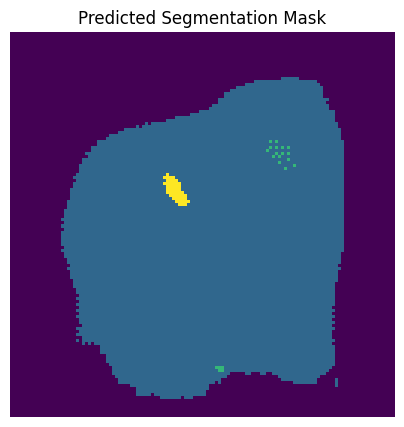

In [50]:
plt.figure(figsize=(5, 5))
plt.imshow(pred_mask)
plt.title("Predicted Segmentation Mask")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


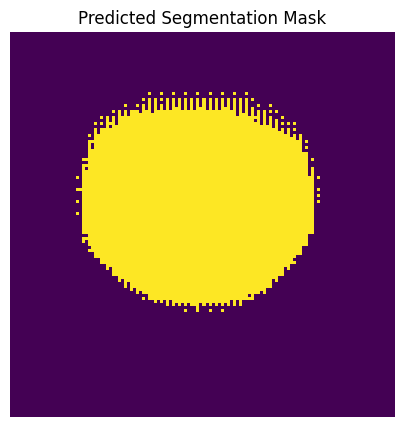

In [55]:
input_image = preprocess_uploaded_image("/content/background.png")
prediction = model.predict(input_image)
pred_mask = tf.argmax(prediction[0], axis=-1).numpy()
plt.figure(figsize=(5, 5))
plt.imshow(pred_mask)
plt.title("Predicted Segmentation Mask")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


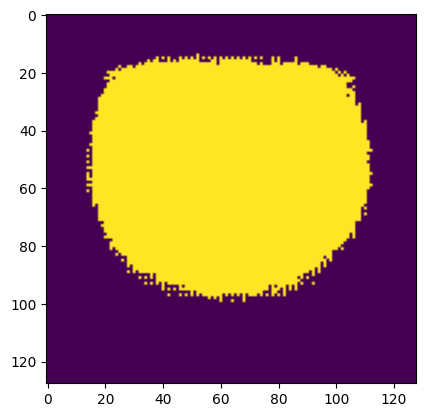

In [53]:
# random pixels
random_img = tf.random.uniform((128, 128, 3))
random_img = tf.expand_dims(random_img, 0)
pred = model.predict(random_img)
plt.imshow(tf.argmax(pred[0], axis=-1))


In [54]:
# prediction image size (123,123)
img = preprocess_image(image_paths[0])
pred = model.predict(tf.expand_dims(img, 0))
label = tf.argmax(pred[0][123, 123]).numpy()
print("Predicted class at (123, 123):", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class at (123, 123): 0
